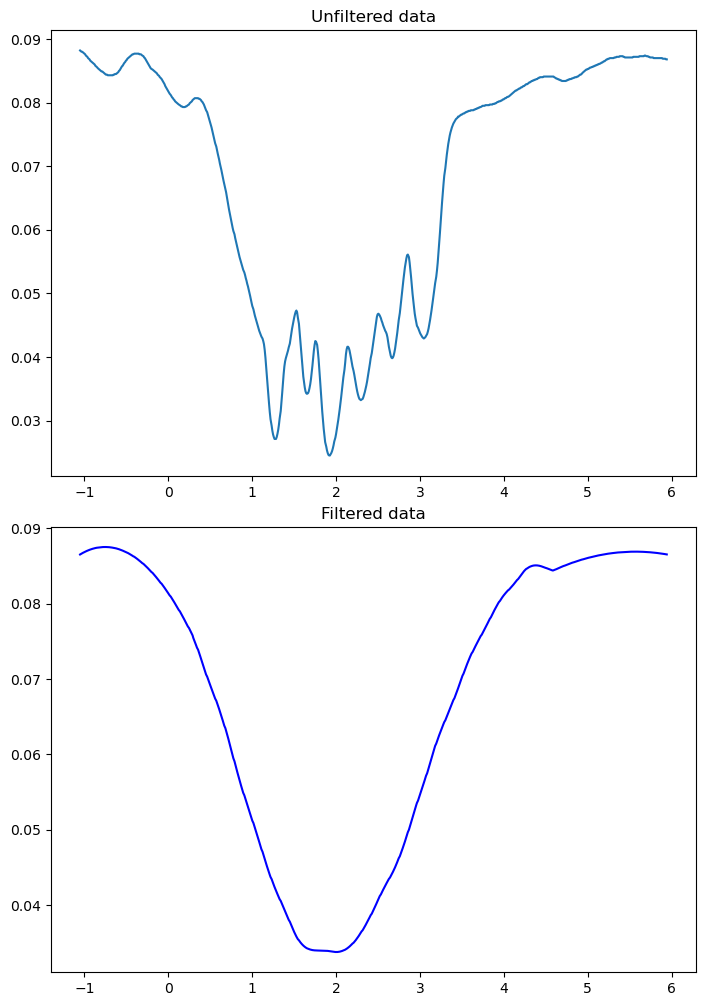

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from scipy.signal import savgol_filter


data=pd.read_csv('947746_05.txt', skiprows=31, sep='\t')
data.columns=['Timestamp','Channel A','Unnamed']#Giving labels to columns Note:An extra column comes up data_4[:,1]hen you read which is given the name unnamed

data_1=data.drop('Unnamed',axis=1)
data_1['Channel A']=pd.to_numeric(data_1['Channel A'],errors='coerce')#Converting to numeric type with invalid parsing set to NaN
data_2=data_1.dropna()#Removing missing values i.e NaN
data_3=data_2.to_numpy()

linear_velocity=8/59

data_3[:,0]=data_3[:,0]*linear_velocity#to convert time into distance in the timestamp column
data_3[:,0]=data_3[:,0]-1.05

data_4=np.empty(data_3.shape)
data_4[:,:]=data_3[:,:]
data_4[:,1] = savgol_filter(data_4[:,1], 300, 2)#applying filter

fig,axis=plt.subplots(2,1,figsize=(7,10))
axis[0].plot(data_3[:,0],data_3[:,1])
axis[0].set_title("Unfiltered data")

axis[1].plot(data_4[:,0], data_4[:,1], 'b')  # smooth by filter
axis[1].set_title("Filtered data")
fig.tight_layout(pad=0.5)
plt.show()

The non-linear absorption coefficient is:  (-5.3+/-2.1)e-19


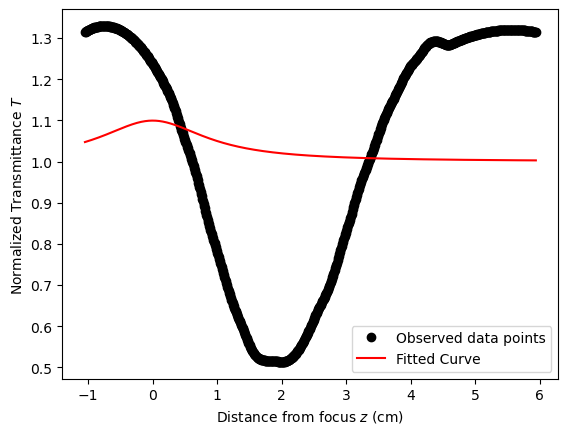

In [16]:
from scipy.optimize import curve_fit

def open_ap(z, del_psi0, N):
    return N*(1 - del_psi0/(z**2+1))

def closed_ap(z, del_psi0, del_phi0, N):
    return N*(1 + 4*del_phi0*z/((z**2+9)*(z**2+1)) - del_psi0/(z**2+1))

popt, pcov = curve_fit(open_ap, data_4[:,0], data_4[:,1])

norm_val = popt[1]

err_psi = np.sqrt(np.diag(pcov))
psifi = ufloat(popt[0], err_psi[0])

p_av = ufloat(60e-3, 1e-3)
f_rep = ufloat(6e3, 1e3)
plwd = ufloat(500e-12,0)
w_0 = ufloat(20e-6,1e-6)
lam = ufloat(532e-9,0)
k = 2*np.pi/lam
I_0 = p_av/f_rep/plwd/np.pi/(w_0)**2
L_eff = ufloat(1e-3, 0.1e-3)
beta = psifi/k/I_0/L_eff

print('The non-linear absorption coefficient is: ', beta)
plt.plot(data_4[:,0], data_4[:,1]/norm_val, 'ko', label="Observed data points")


plt.plot(data_4[:,0], open_ap(data_4[:,0], *popt)/norm_val, 'r-', label="Fitted Curve")

plt.xlabel('Distance from focus $z$ (cm)')
plt.ylabel('Normalized Transmittance $T$')
plt.legend()
plt.savefig("tol-o.png", dpi = 1200, bbox_inches='tight')
